## Assumptions

### 1: Houses in the city will be more expensive in comparison to houses in the countryside

### 2: Big houses will be more expensive than smaller houses(both in the city and countryside)

### 3: Applying the wishes of stakeholder (aprox. 2 bedrooms, good condition, splitting city/countryside, no renovation in the countryside house) will be possible 

### 4: Big house in the city + big house in the countryside will be most expensive combination

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import folium
from folium.plugins import HeatMap

In [3]:
# read the original file
df = pd.read_csv("King_County_house_prices_dataset.csv")

# handling bathrooms
df["bathrooms"] = df["bathrooms"].apply(lambda x: round(x))

# convert variables
# following variables are in thousand dollars and sqft
df["price"] = df["price"].apply(lambda x: x*0.001)
df["sqft_lot"] = df["sqft_lot"].apply(lambda x: x*0.001)
df["sqft_living"] = df["sqft_living"].apply(lambda x: x*0.001)
df["sqft_above"] = df["sqft_above"].apply(lambda x: x*0.001)
df["sqft_living15"] = df["sqft_living15"].apply(lambda x: x*0.001)
df["sqft_lot15"] = df["sqft_lot15"].apply(lambda x: x*0.001)

df.sqft_basement = pd.to_numeric(df.sqft_basement, errors='coerce')
df["sqft_basement"] = df["sqft_basement"].apply(lambda x: x*0.001)

df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221.9,3,1,1.18,5.650,1.0,NaN,0.0,...,7,1.18,0.00,1955,0.0,98178,47.5112,-122.257,1.34,5.650
1,6414100192,12/9/2014,538.0,3,2,2.57,7.242,2.0,0.0,0.0,...,7,2.17,0.40,1951,1991.0,98125,47.7210,-122.319,1.69,7.639
2,5631500400,2/25/2015,180.0,2,1,0.77,10.000,1.0,0.0,0.0,...,6,0.77,0.00,1933,NaN,98028,47.7379,-122.233,2.72,8.062
3,2487200875,12/9/2014,604.0,4,3,1.96,5.000,1.0,0.0,0.0,...,7,1.05,0.91,1965,0.0,98136,47.5208,-122.393,1.36,5.000
4,1954400510,2/18/2015,510.0,3,2,1.68,8.080,1.0,0.0,0.0,...,8,1.68,0.00,1987,0.0,98074,47.6168,-122.045,1.80,7.503


# Split the data in city and nature dataframes

### The nature data frame

In [5]:
df_nature = df.query("long >= -122")
df_nature.shape
#df_nature.long.describe()

(1496, 21)

(1018, 21)


count    1496.000000
mean      519.940936
std       261.215365
min        80.000000
25%       345.000000
50%       470.975000
75%       633.975500
max      2700.000000
Name: price, dtype: float64

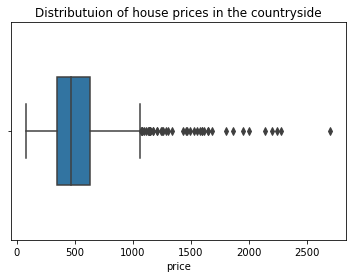

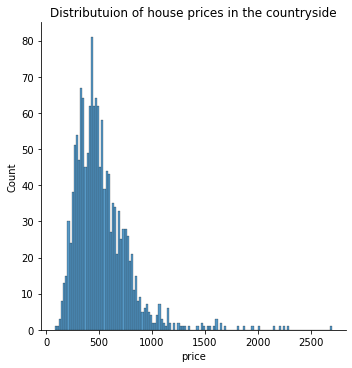

In [8]:
sns.boxplot( x=df_nature["price"], width=0.5).set_title('Distributuion of house prices in the countryside');
sns.displot(df_nature, x=df_nature["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the countryside")
df_nature.price.describe()

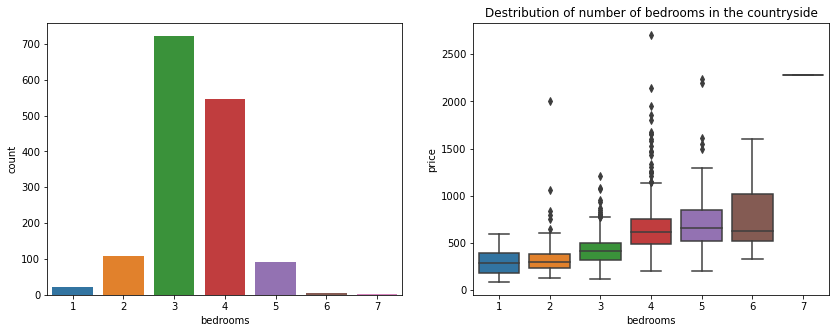

Text(0.5, 1.0, 'Scatter plot')

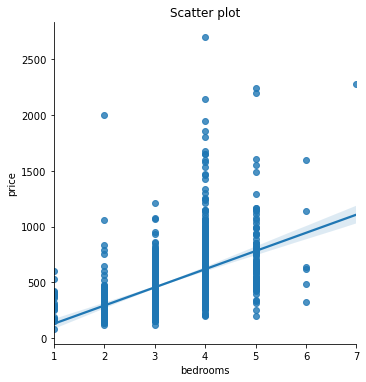

In [10]:
warnings.filterwarnings('ignore')

bedrooms = df_nature["bedrooms"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))

sns.countplot(x='bedrooms', data=df_nature, ax=ax[0])
plt.title("Destribution of number of bedrooms in the countryside")
sns.boxplot(x='bedrooms', y= 'price',
            data=df_nature, ax=ax[1])

plt.show()


sns.lmplot('bedrooms', 'price',data=df_nature);
plt.title("Scatter plot")

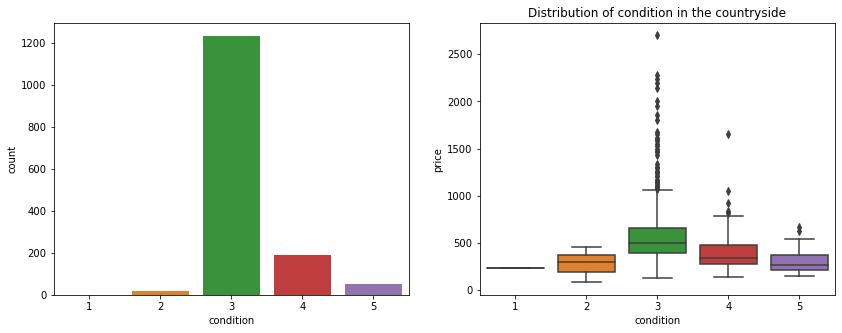

Text(0.5, 1.0, 'Scatter plot')

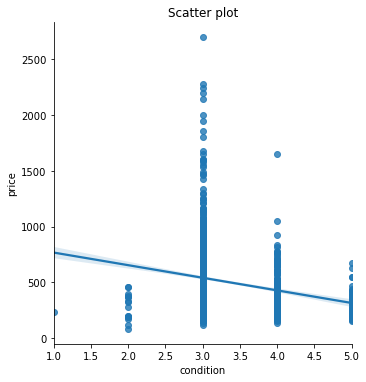

In [11]:
warnings.filterwarnings('ignore')

condition = df_nature["condition"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='condition', data=df_nature, ax=ax[0])
plt.title("Distribution of condition in the countryside")
sns.boxplot(x='condition', y= 'price',
            data=df_nature, ax=ax[1])
plt.show()

sns.lmplot('condition', 'price',data=df_nature);
plt.title("Scatter plot")

### Add filters

In [63]:
df_nature = df_nature.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3 and price <= 633 and yr_renovated == 0.0")
print(df_nature.shape)

(795, 21)


count    795.000000
mean     407.769019
std      112.334248
min      122.000000
25%      320.000000
50%      415.000000
75%      499.215500
max      619.000000
Name: price, dtype: float64

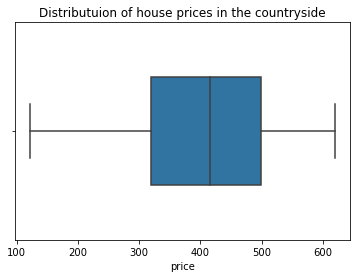

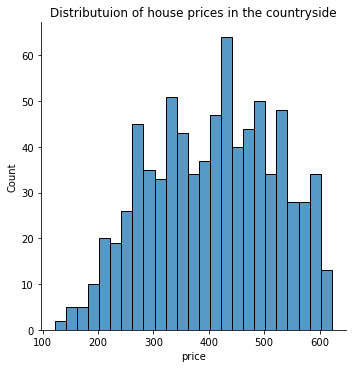

In [64]:
sns.boxplot( x=df_nature["price"], width=0.5).set_title('Distributuion of house prices in the countryside');
sns.displot(df_nature, x=df_nature["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the countryside")
df_nature.price.describe()

In [65]:
# Visualizing the surrounding 
maxpr=df_nature.loc[df_nature['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_nature_copy = df_nature.copy()
df_nature_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_nature_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

## The city dataframe

In [66]:
df_city = df.query("long < -122")
df_city.shape
#df_city.long.describe()

(20101, 21)

count    20101.000000
mean       541.811525
std        374.026570
min         78.000000
25%        320.000000
50%        450.000000
75%        645.000000
max       7700.000000
Name: price, dtype: float64

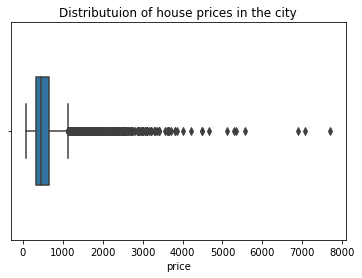

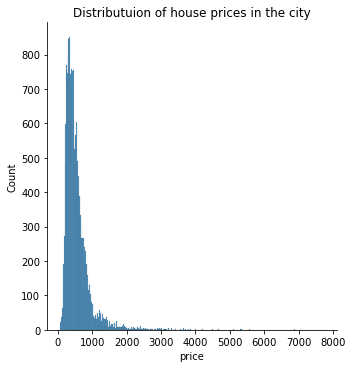

In [67]:
sns.boxplot( x=df_city["price"], width=0.5).set_title('Distributuion of house prices in the city');
sns.displot(df_city, x=df_city["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the city")
df_city.price.describe()

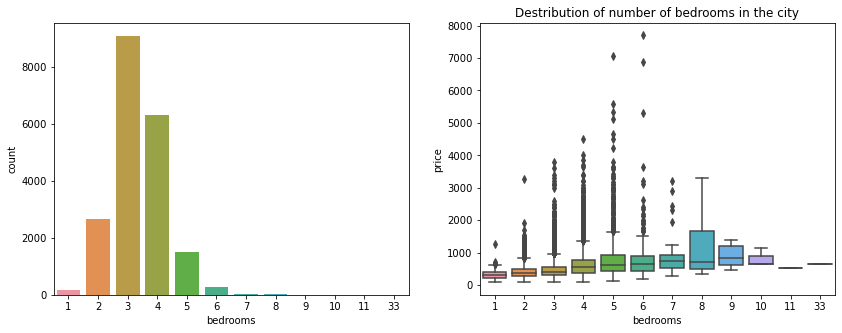

Text(0.5, 1.0, 'Scatter plot')

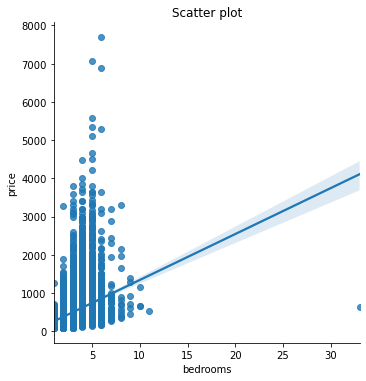

In [68]:
warnings.filterwarnings('ignore')

bedrooms = df_city["bedrooms"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))

sns.countplot(x='bedrooms', data=df_city, ax=ax[0])
plt.title("Destribution of number of bedrooms in the city")
sns.boxplot(x='bedrooms', y= 'price',
            data=df_city, ax=ax[1])

plt.show()


sns.lmplot('bedrooms', 'price',data=df_city);
plt.title("Scatter plot")

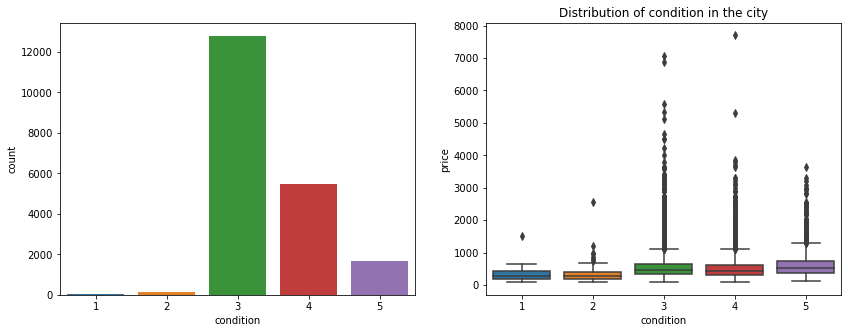

Text(0.5, 1.0, 'Scatter plot')

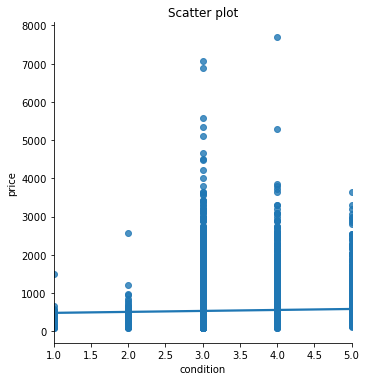

In [69]:
warnings.filterwarnings('ignore')

condition = df_city["condition"].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='condition', data=df_city, ax=ax[0])
plt.title("Distribution of condition in the city")
sns.boxplot(x='condition', y= 'price',
            data=df_city, ax=ax[1])
plt.show()

sns.lmplot('condition', 'price',data=df_city);
plt.title("Scatter plot")

### Add filters

In [70]:
# filter
df_city = df_city.query("bedrooms >= 2 and bedrooms <= 4 and condition >= 3 and price <= 645")
df_city.shape

(13807, 21)

count    13807.000000
mean       389.569268
std        126.110205
min         82.000000
25%        288.000000
50%        380.000000
75%        489.950000
max        645.000000
Name: price, dtype: float64

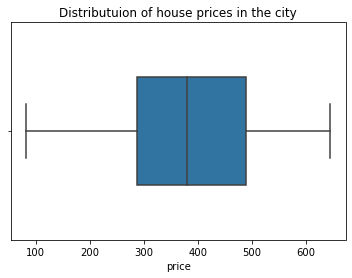

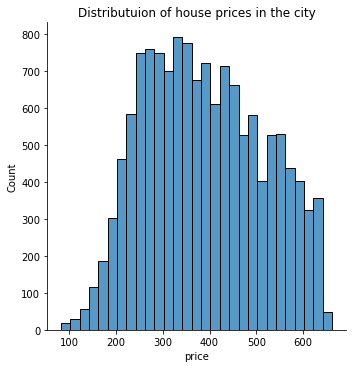

In [71]:
sns.boxplot( x=df_city["price"], width=0.5).set_title('Distributuion of house prices in the city');
sns.displot(df_city, x=df_city["price"], bins=100, binwidth=20);
plt.title("Distributuion of house prices in the city")
df_city.price.describe()

In [72]:
# Visualizing the surrounding 
maxpr=df_city.loc[df_city['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

df_city_copy = df_city.copy()
df_city_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=df_city_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

# Splitting into big and small houses

#### Nature

In [73]:
print(df_nature.sqft_living.describe())
print(df_nature.shape)

count    795.000000
mean       1.973875
std        0.615302
min        0.490000
25%        1.515000
50%        1.920000
75%        2.400000
max        4.040000
Name: sqft_living, dtype: float64
(795, 21)


In [74]:
df_nature_small = df_nature.query("sqft_living <= sqft_living.median()")
df_nature_small.shape

(401, 21)

count    401.000000
mean     335.967259
std       91.226240
min      122.000000
25%      272.000000
50%      330.000000
75%      399.950000
max      610.000000
Name: price, dtype: float64

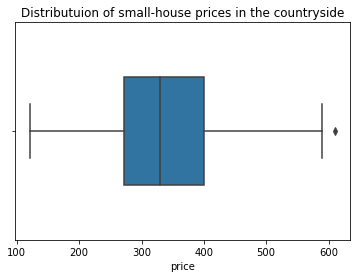

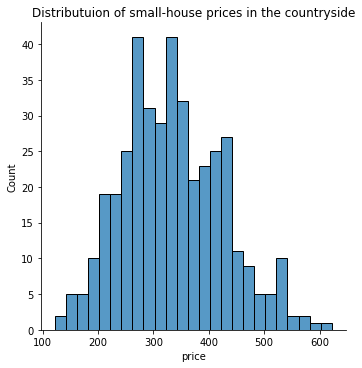

In [75]:
sns.boxplot( x=df_nature_small["price"], width=0.5).set_title('Distributuion of small-house prices in the countryside');
sns.displot(df_nature_small, x=df_nature_small["price"], bins=100, binwidth=20);
plt.title("Distributuion of small-house prices in the countryside")
df_nature_small.price.describe()

In [76]:
df_nature_big = df_nature.query("sqft_living > sqft_living.median()")
df_nature_big.shape

(394, 21)

count    394.000000
mean     480.846444
std       80.062749
min      208.633000
25%      430.000000
50%      489.250000
75%      540.000000
max      619.000000
Name: price, dtype: float64

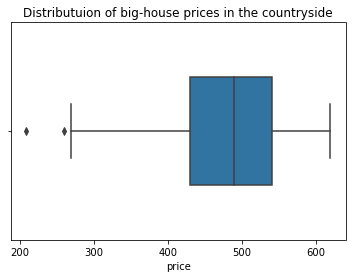

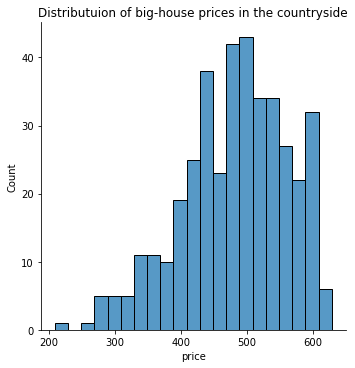

In [77]:
sns.boxplot( x=df_nature_big["price"], width=0.5).set_title('Distributuion of big-house prices in the countryside');
sns.displot(df_nature_big, x=df_nature_big["price"], bins=100, binwidth=20);
plt.title("Distributuion of big-house prices in the countryside")
df_nature_big.price.describe()

#### City

In [78]:
print(df_city.sqft_living.describe())
print(df_city.shape)

count    13807.000000
mean         1.721240
std          0.583643
min          0.440000
25%          1.290000
50%          1.650000
75%          2.080000
max          5.461000
Name: sqft_living, dtype: float64
(13807, 21)


In [79]:
df_city_small = df_city.query("sqft_living <= sqft_living.median()")
df_city_small.shape

(6931, 21)

count    6931.000000
mean      348.580027
std       119.482437
min        82.000000
25%       250.000000
50%       337.000000
75%       435.000000
max       645.000000
Name: price, dtype: float64

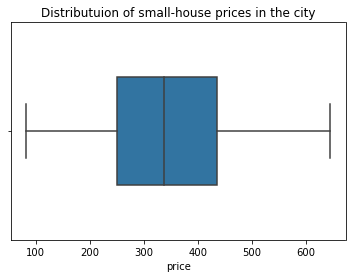

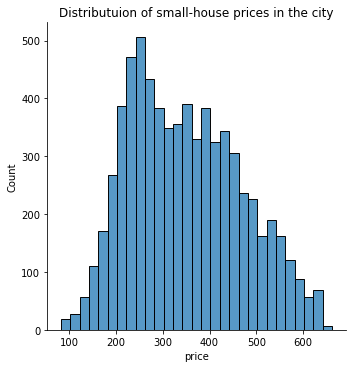

In [80]:
sns.boxplot( x=df_city_small["price"], width=0.5).set_title('Distributuion of small-house prices in the city');
sns.displot(df_city_small, x=df_city_small["price"], bins=100, binwidth=20);
plt.title("Distributuion of small-house prices in the city")
df_city_small.price.describe()

In [81]:
df_city_big = df_city.query("sqft_living > sqft_living.median()")
df_city_big.shape

(6876, 21)

count    6876.000000
mean      430.886376
std       118.935676
min       148.900000
25%       330.000000
50%       429.000000
75%       535.000000
max       645.000000
Name: price, dtype: float64

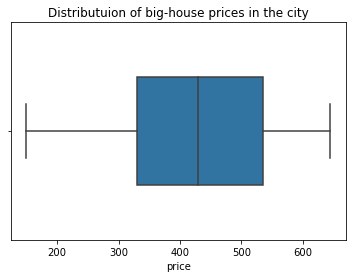

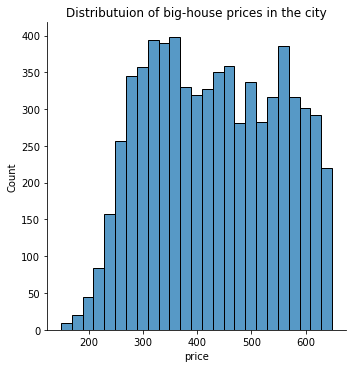

In [82]:
sns.boxplot( x=df_city_big["price"], width=0.5).set_title('Distributuion of big-house prices in the city');
sns.displot(df_city_big, x=df_city_big["price"], bins=100, binwidth=20);
plt.title("Distributuion of big-house prices in the city")
df_city_big.price.describe()

## Join the tables

### small_city and small_countryside

In [83]:
df_city_small['key'] = 1
df_nature_small['key'] = 1

result_cs_ns = pd.merge(df_city_small, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1) 

In [84]:
result_cs_ns["price"] = result_cs_ns["price_city"] + result_cs_ns["price_nature"]

count    2.779331e+06
mean     6.845473e+02
std      1.502514e+02
min      2.040000e+02
25%      5.744000e+02
50%      6.761000e+02
75%      7.875000e+02
max      1.255000e+03
Name: price, dtype: float64

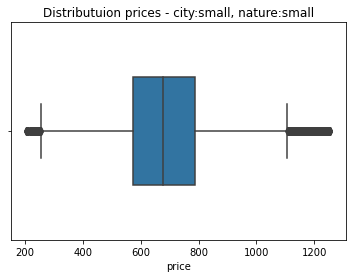

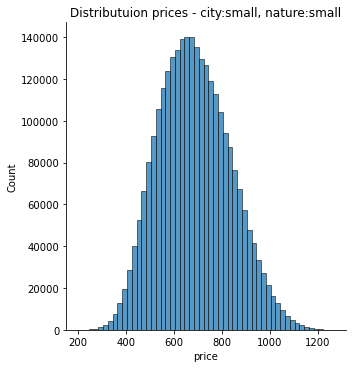

In [85]:
sns.boxplot( x=result_cs_ns["price"], width=0.5).set_title('Distributuion prices - city:small, nature:small');
sns.displot(result_cs_ns, x=result_cs_ns["price"], bins=100, binwidth=20);
plt.title("Distributuion prices - city:small, nature:small")
result_cs_ns.price.describe()

### big_city and small_countryside

In [86]:
df_city_big['key'] = 1
df_nature_small['key'] = 1

result_cb_ns = pd.merge(df_city_big, df_nature_small, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_ns["price"] = result_cb_ns["price_city"] + result_cb_ns["price_nature"]

count    2.757276e+06
mean     7.668536e+02
std      1.498170e+02
min      2.709000e+02
25%      6.550000e+02
50%      7.650000e+02
75%      8.749500e+02
max      1.255000e+03
Name: price, dtype: float64

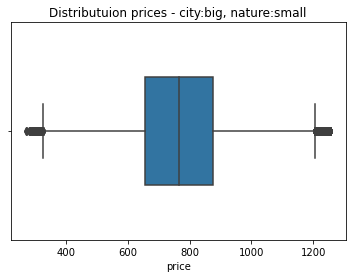

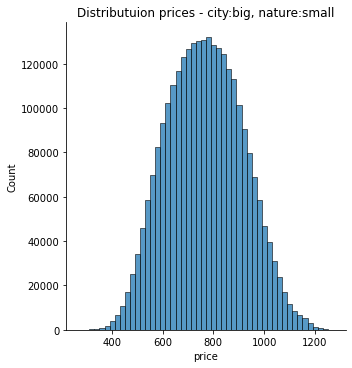

In [87]:
sns.boxplot( x=result_cb_ns["price"], width=0.5).set_title('Distributuion prices - city:big, nature:small');
sns.displot(result_cb_ns, x=result_cb_ns["price"], bins=100, binwidth=20);
plt.title("Distributuion prices - city:big, nature:small")
result_cb_ns.price.describe()

### small_city and big_countryside

In [88]:
df_city_small['key'] = 1
df_nature_big['key'] = 1

result_cs_nb = pd.merge(df_city_small, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cs_nb["price"] = result_cs_nb["price_city"] + result_cs_nb["price_nature"]

count    2.730814e+06
mean     8.294265e+02
std      1.437629e+02
min      2.906330e+02
25%      7.272200e+02
50%      8.239000e+02
75%      9.300000e+02
max      1.264000e+03
Name: price, dtype: float64

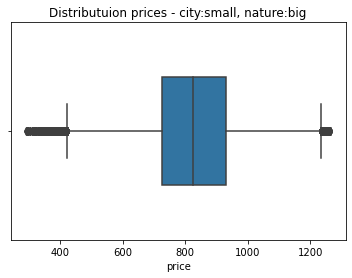

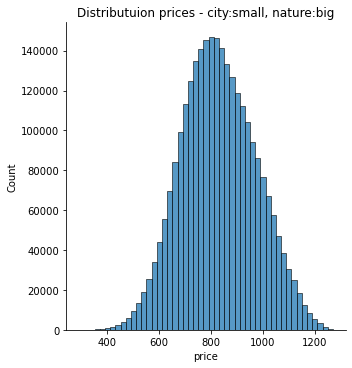

In [89]:
sns.boxplot( x=result_cs_nb["price"], width=0.5).set_title('Distributuion prices - city:small, nature:big');
sns.displot(result_cs_nb, x=result_cs_nb["price"], bins=100, binwidth=20);
plt.title("Distributuion prices - city:small, nature:big")
result_cs_nb.price.describe()

### big_city and big_countryside

In [90]:
df_city_big['key'] = 1
df_nature_big['key'] = 1

result_cb_nb = pd.merge(df_city_big, df_nature_big, on ='key', suffixes=("_city", "_nature")).drop("key", 1)
result_cb_nb["price"] = result_cb_nb["price_city"] + result_cb_nb["price_nature"]

count    2.709144e+06
mean     9.117328e+02
std      1.433088e+02
min      3.575330e+02
25%      8.080000e+02
50%      9.100000e+02
75%      1.020000e+03
max      1.264000e+03
Name: price, dtype: float64

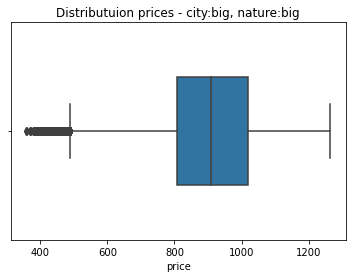

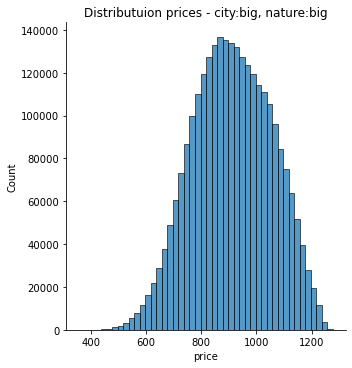

In [91]:
sns.boxplot( x=result_cb_nb["price"], width=0.5).set_title('Distributuion prices - city:big, nature:big');
sns.displot(result_cb_nb, x=result_cb_nb["price"], bins=100, binwidth=20);
plt.title("Distributuion prices - city:big, nature:big")
result_cb_nb.price.describe()

In [95]:
print("city:small and nature:small")
print("median: ", result_cs_ns.price.median(), "mean: ", result_cs_ns.price.mean() )
print("")
print("city:big and nature:small")
print("median: ", result_cb_ns.price.median(), "mean: ", result_cb_ns.price.mean() )
print("")
print("city:small and nature:big")
print("median: ", result_cs_nb.price.median(), "mean: ", result_cs_nb.price.mean() )
print("")
print("city:big and nature:big")
print("median: ", result_cb_nb.price.median(), "mean: ", result_cb_nb.price.mean() )

city:small and nature:small
median:  676.1 mean:  684.5472861875755

city:big and nature:small
median:  765.0 mean:  766.8536352969388

city:small and nature:big
median:  823.9000000000001 mean:  829.4264709983906

city:big and nature:big
median:  910.0 mean:  911.7328201077536
